In [2]:
#!pip install git+https://github.com/openai/glide-text2im
#!pip install matplotlib Js2Py numpy==1.23

### Library import

In [3]:
import time

from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import Tuple
#from google.colab.output import eval_js
from js2py import eval_js
import base64

from glide_text2im.clip.model_creation import create_clip_model
from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)
from glide_text2im.tokenizer.simple_tokenizer import SimpleTokenizer

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda:1')
print("device: ", device)

device:  cuda:1


### Define functions

In [4]:
# Tensor image display
def show_images(batch: th.Tensor):
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

# Read image
def read_image(path: str, size: int = 256) -> Tuple[th.Tensor, th.Tensor]:
    pil_img = Image.open(path).convert('RGB')
    pil_img = pil_img.resize((size, size), resample=Image.BICUBIC)
    img = np.array(pil_img)
    print(img.shape)
    return th.from_numpy(img)[None].permute(0, 3, 1, 2).float() / 127.5 - 1

# Read mask
def read_image_mask(path: str, size: int = 256) -> Tuple[th.Tensor, th.Tensor]:
    pil_img = Image.open(path).convert(mode="L")
    pil_img = pil_img.resize((size, size), resample=Image.BICUBIC)
    img = np.array(pil_img)
    img = np.where(img != 255, 0, img)
    img = np.where(img == 255, 1, img)
    th_img = th.from_numpy(img)
    th_img = th.unsqueeze(th_img, 0)
    th_img = th.unsqueeze(th_img, 0)
    return th_img

### Text-to-Image (Classifier-free guidance)

In [5]:
# Input query
prompt = "an oil painting of cherry blossoms." # @param {type:"string"} 
batch_size = 5 # batch size(how many generate images)

# Scale of guidance
# Bigger scale, more various images generated...
guidance_scale = 5.0

# Parameter for upsampling 64x64 to 256x256
# 1.0で最もシャープに仕上がる一方歪みが出る可能性が高くなる。
upsample_temp = 0.997

In [6]:
# Load default settings for classifier-free guidance
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda

# diffusion steps
options['timestep_respacing'] = '100'

# define model
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

total base parameters 385030726


In [7]:
# upsamplerのデフォルト設定ロード
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27'

# モデルの作成
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

total upsampler parameters 398361286


  0%|          | 0/100 [00:00<?, ?it/s]

Inference time: 10769.073725 ms


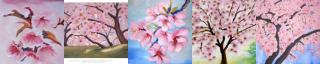

In [8]:
# 条件付き画像生成のためテキストをエンコードし、トークン生成
# options['text_ctx']で指定の長さ128の配列に揃えるようパディング
# maskはパディング箇所を示す
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

# 無条件画像生成のため空のトークンを生成
full_batch_size = batch_size * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

# モデルへの引数定義
model_kwargs = dict(
    # トークン
    tokens=th.tensor(
        [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
    ),
    # mask
    mask=th.tensor(
        [mask] * batch_size + [uncond_mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

# classifier-free guidanceによるサンプリング関数定義
def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

start = time.time()

# サンプリング
model.del_cache()
samples = diffusion.p_sample_loop(
    model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model.del_cache()

end = time.time()
print('Inference time: %2f ms'% ((end - start)*1000.))

# 生成結果出力
show_images(samples)

  0%|          | 0/27 [00:00<?, ?it/s]

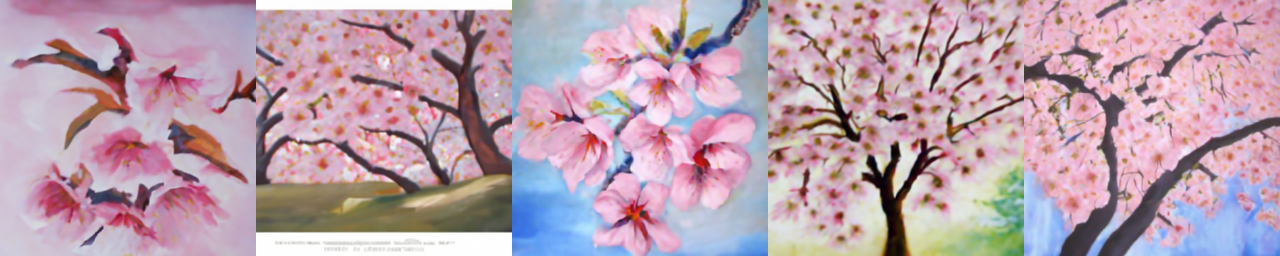

In [9]:
# 64x64の生成画像を256x256にアップサンプリング
tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# モデルの引数定義
model_kwargs = dict(
    # アップサンプリング対象画像
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # テキストトークン
    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

# サンプリング
model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.ddim_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model_up.del_cache()

# アップサンプリング結果表示
show_images(up_samples)

### Text-to-Image (CLIP Guidance)

In [10]:
# CLIPモデル作成
clip_model = create_clip_model(device=device)
clip_model.image_encoder.load_state_dict(load_checkpoint('clip/image-enc', device))
clip_model.text_encoder.load_state_dict(load_checkpoint('clip/text-enc', device))

<All keys matched successfully>

  0%|          | 0/100 [00:00<?, ?it/s]

Inference time: 10882.807970 ms


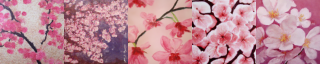

In [11]:
# テキストをエンコード
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

# モデルへの引数定義
model_kwargs = dict(
    tokens=th.tensor([tokens] * batch_size, device=device),
    mask=th.tensor([mask] * batch_size, dtype=th.bool, device=device),
)

# CLIPによるサンプリング関数定義
cond_fn = clip_model.cond_fn([prompt] * batch_size, guidance_scale)

start = time.time()

# サンプリング
model.del_cache()
samples = diffusion.p_sample_loop(
    model,
    (batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=cond_fn,
)
model.del_cache()

end = time.time()
print('Inference time: %2f ms'% ((end - start)*1000.))

# 生成結果出力
show_images(samples)

  0%|          | 0/27 [00:00<?, ?it/s]

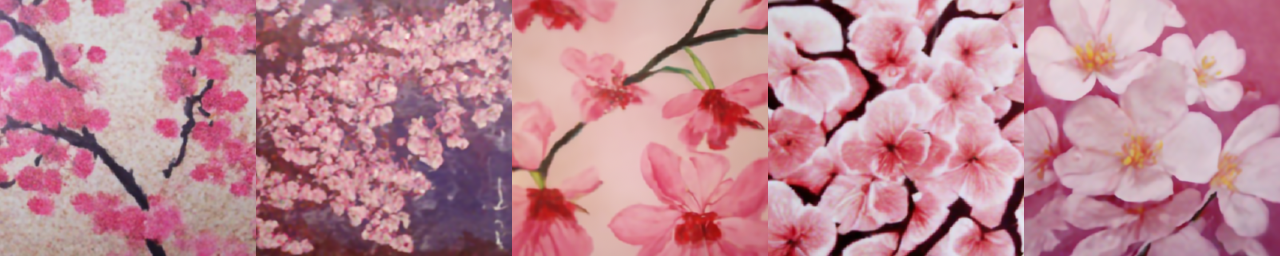

In [12]:
# 64x64の生成画像を256x256にアップサンプリング
tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# モデルの引数定義
model_kwargs = dict(
    # アップサンプリング対象画像
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # テキストトークン
    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

# サンプリング
model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.ddim_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model_up.del_cache()

# アップサンプリング結果表示
show_images(up_samples)

### Inpainting

In [14]:
img_path = "test.jpg"
mask_path = "test_mask.png"

!wget -c https://www.pakutaso.com/shared/img/thumb/maeda3gou1230064_TP_V4.jpg \
      -O {img_path}

--2023-02-09 14:15:37--  https://www.pakutaso.com/shared/img/thumb/maeda3gou1230064_TP_V4.jpg
Resolving www.pakutaso.com (www.pakutaso.com)... 180.235.251.31
Connecting to www.pakutaso.com (www.pakutaso.com)|180.235.251.31|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [15]:
canvas_html = """
<style>
.button {
  background-color: #4CAF50;
  border: none;
  color: white;
  padding: 15px 32px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;
  margin: 4px 2px;
  cursor: pointer;
}
</style>
<canvas1 width=%d height=%d>
</canvas1>
<canvas width=%d height=%d>
</canvas>

<button class="button">Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

var canvas1 = document.querySelector('canvas1')
var ctx1 = canvas.getContext('2d')


ctx.strokeStyle = 'red';

var img = new Image();
img.src = "data:image/%s;charset=utf-8;base64,%s";
console.log(img)
img.onload = function() {
  ctx1.drawImage(img, 0, 0);
};
img.crossOrigin = 'Anonymous';

ctx.clearRect(0, 0, canvas.width, canvas.height);

ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

# 修復範囲指定用HTMLを描画
def draw(imgm, filename='drawing.png', w=400, h=200, line_width=1):
    display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
    data = eval_js("data")
    binary = base64.b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)

In [16]:
img = np.array(plt.imread(f'{img_path}',0)[:,:,:3])
image64 = base64.b64encode(open(img_path, 'rb').read())
image64 = image64.decode('utf-8')
draw(image64, filename=mask_path, w=img.shape[1], h=img.shape[0], line_width=0.04*img.shape[1])

JsException: ReferenceError: data is not defined

In [17]:
# マスク画像指定
with_mask = np.array(plt.imread(mask_path)[:,:,:3])
mask = (with_mask[:,:,0]==1)*(with_mask[:,:,1]==0)*(with_mask[:,:,2]==0)
plt.imsave(mask_path,mask, cmap='gray')

im = Image.open(mask_path).convert('RGB')
im_invert = ImageOps.invert(im)
im_invert.save(mask_path)

FileNotFoundError: [Errno 2] No such file or directory: 'test_mask.png'